In [89]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Bio.PDB.Polypeptide as pp
sys.path.append('/Users/macbook/Documents/GitHub/perturbation-networks-get-data')
from getmutations import MutationsDict, GetMutations
%matplotlib inline

In [2]:
AA = list(pp.aa1)

In [305]:
path = "/Users/macbook/Documents/perturbation-networks/dms_data"
protein_path = "/Users/macbook/Documents/perturbation-networks/proteins"

In [4]:
def PlotHeatmap(dataframe, save_as=None, vmin=None, vmax=None):
    """Plot heatmap of dataframe values.
    
    Parameters:
        dataframe: data to plot
        save_as: name of file to save. If None, image is not saved
        vmin, vmax: min and max values for colorscale
    """
    # Set missing values gray 
    sns.set(rc={'axes.facecolor':'94A3A8'})
    # Set size to match dataframe dimensions
    w = len(dataframe.columns)
    h = len(dataframe.index)
    ratio = w//h
    plt.figure(figsize=(10*ratio,10))
    heatmap = sns.heatmap(dataframe, cmap='RdBu_r', center=0, cbar=True, square=True, vmin=vmin, vmax=vmax)
    if save_as:
        fig = heatmap.get_figure()
        fig.savefig(f'{save_as}.png')
    return

## Deep Mutational Scanning Data

Processing different formats of deep mutational scanning data into DataFrames, with columns being positions, index being aminoacids.

### 1be9

In [350]:
# Positions from PDB file 
pdb_file = os.path.join(protein_path, '1be9/1be9.pdb')
mutations = MutationsDict(pdb_file, positions=[('A', 311, 393)])
mutations = [mutation[0]+mutation[2:] for mutation in mutations.keys()]

In [351]:
functional_1be9 = pd.read_csv(os.path.join(path, "1be9_functional.csv"), names=mutations)
functional_1be9.index = AA

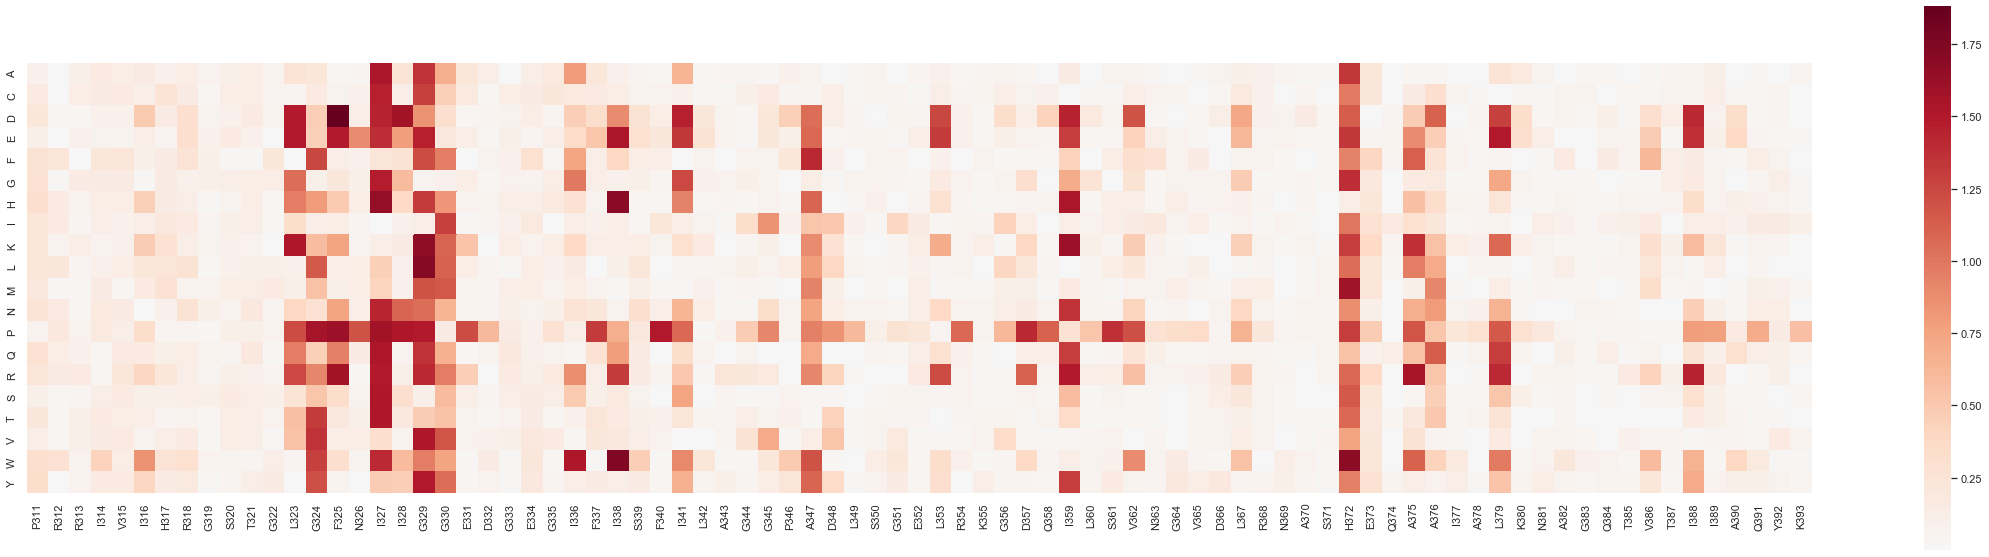

In [352]:
PlotHeatmap(functional_1be9)

### 1d5r

In [306]:
file = os.path.join(path, "1d5r_functional.csv")
funct_1d5r = pd.read_csv(file, header=0, index_col=0, usecols=[0, 6, 8, 10])

In [307]:
# Use index to get position list 
positions = []
index_list = list(funct_1d5r.index)
for index in index_list:
    #index has format A#A
    position = index[:-1]
    positions.append(position)
# Remove duplicates and sort according to position number
positions = list(set(positions))
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons, '~' for deletions
#AAstop = AA + ['*', '~']
functional_1d5r = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [308]:
# If high confidence, we keep the cum_score, else, we keep imputed_score
for index, row in funct_1d5r.iterrows():
    original = index[:-1]
    mutation = index[-1]
    if mutation.isalpha():
        if row[1] == 'VERDADERO':
            functional_1d5r.at[mutation, original] = funct_1d5r.at[index, 'Cum_score']
        else:
            functional_1d5r.at[mutation, original] = funct_1d5r.at[index, 'Imputed_Score']

In [309]:
# Only keep positions for which we also have pdb data
pdb_file = os.path.join(protein_path, '1d5r/1d5r.pdb')
mutations = list(MutationsDict(pdb_file).keys())
mutations = [mutation[0]+mutation[2:] for mutation in mutations] # remove chain id 
new_positions = [prefix for prefix in positions if prefix in mutations]
functional_1d5r = functional_1d5r[new_positions]

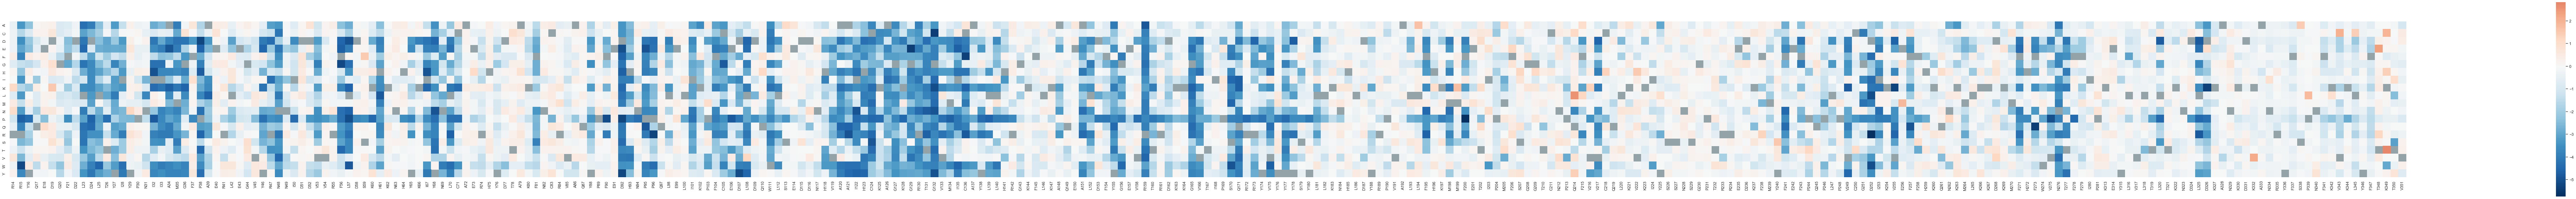

In [311]:
PlotHeatmap(functional_1d5r)

### 3dqw

In [312]:
funct_3dqw = pd.read_csv(os.path.join(path, "3dqw-functional.csv"), index_col=0)
funct_3dqw = funct_3dqw[['Scores']]

In [313]:
# Functional scores are the negative of the scores in the file 
funct_3dqw['Scores'] = funct_3dqw['Scores'].apply(lambda x:-x)

In [314]:
# Use index to get position list 
positions = []
index_list = list(funct_3dqw.index)
for index in index_list:
    #index has format p.AAA#AAA
    original = pp.three_to_one(index[2:5].upper())
    position = original+index[5:-3]
    positions.append(position)
# Remove duplicates and sort according to position number
positions = list(set(positions))
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons
#AAstop = AA + ['*']
functional_3dqw = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [315]:
for index, row in funct_3dqw.iterrows():
    #index has format p.AAA#AAA
    original = index[2:5].upper()
    mutation = index[-3:].upper()
    if pp.is_aa(mutation):
        original = pp.three_to_one(original)
        mutation = pp.three_to_one(mutation)
        position = original+index[5:-3]
        functional_3dqw.at[mutation, position] = row['Scores']
    #else:
    #    original = pp.three_to_one(original)
    #    position = original+index[5:-3]
    #    functional_3dqw.at['*', position] = row['Scores']

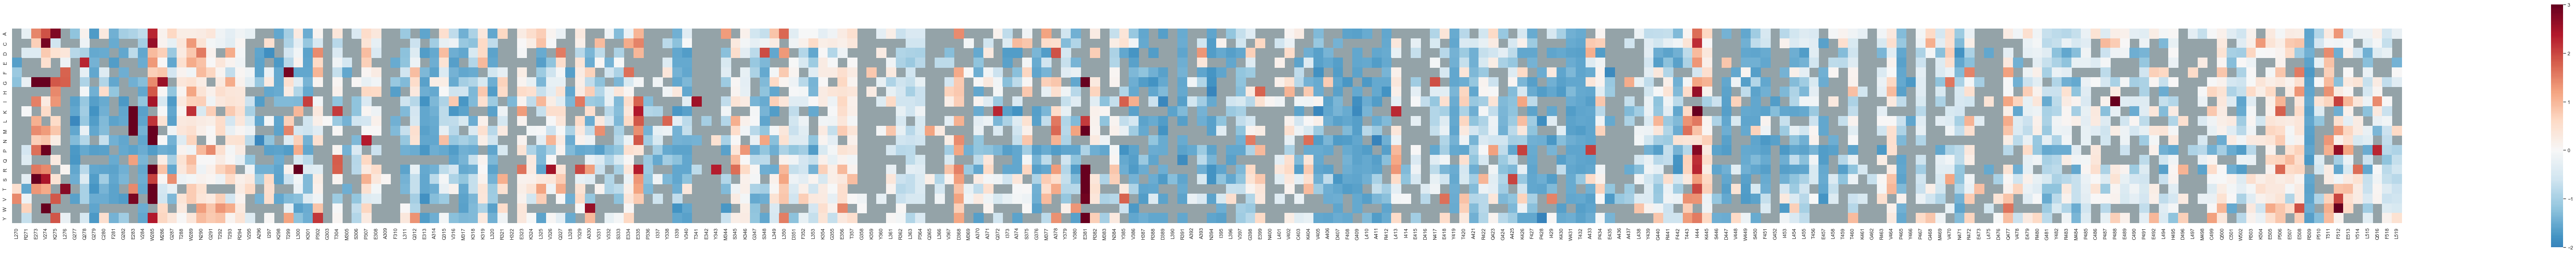

In [316]:
PlotHeatmap(functional_3dqw, vmin=-2, vmax=3)

### 4bz3

In [323]:
file = os.path.join(path, "4bz3_functional.csv")
# We are keeping selection with 128ug/mL AMP at 37C
funct_4bz3 = pd.read_csv(file, header=0, usecols=[1,2,3,12]) 

In [324]:
# Use wt residue and position to get position list 
positions = set()
for index, row in funct_4bz3.iterrows():
    positions.add(row[0]+str(row[1]))
positions = list(positions)
# Sort according to position number
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons
#AAstop = AA + ['*']
functional_4bz3 = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [325]:
for index, row in funct_4bz3.iterrows():
    original = row['wt residue']+str(row['position'])
    mutation = row['variant residue']
    if mutation.isalpha():
        functional_4bz3.at[mutation, original] = funct_4bz3.at[index, '128ug/mL_AMP_37C']

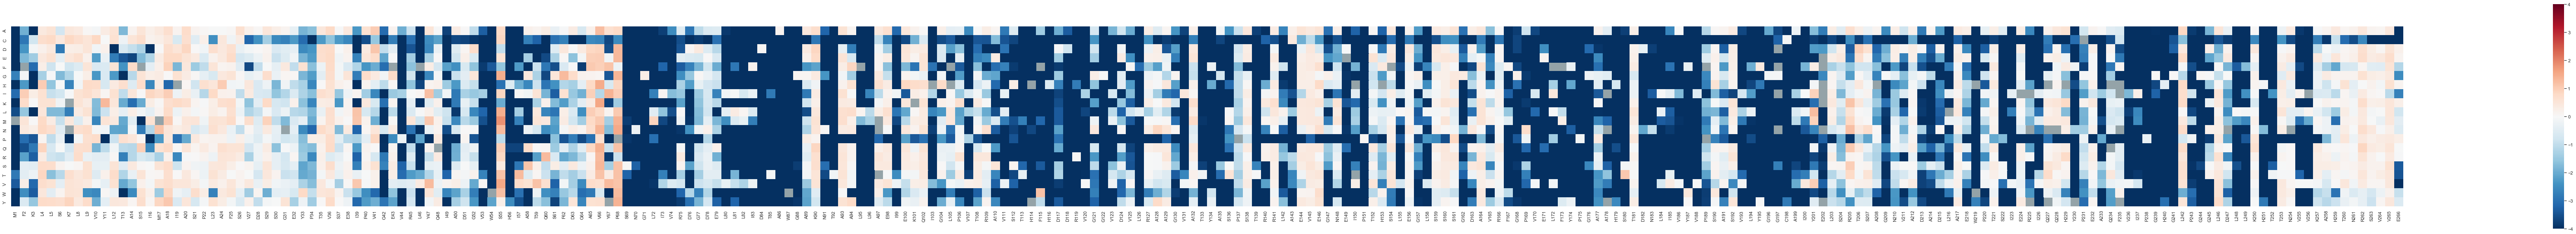

In [326]:
PlotHeatmap(functional_4bz3, vmin=-4, vmax=4)

### 1nd4

In [21]:
def GetDataFrame(file):
    """Get dataframe and fix format issues."""
    df = pd.read_csv(file, sep='\t', skiprows=(0), lineterminator='\n', header = [1,2], index_col = [0])
    df.columns = pd.MultiIndex.from_tuples([(int(ix[0]), ix[1].rstrip()) for ix in df.columns.tolist()])
    return df
# mi yo del pasado escribió eso, no recuerdo por qué necesitaba todo eso para que sirviera, pero es por el formato de 
# los txt

In [22]:
file = os.path.join(path, "1nd4-functional/KKA2_S1_Kan12_L1.aadiff.txt")
# We are keeping selection with 1:2 kanamycin
funct_1nd4 = GetDataFrame(file) 
funct_1nd4 = funct_1nd4.drop(funct_1nd4.index[range(20,40)])

In [23]:
funct_1nd4.at['Delta-G', (1, 'M')] = np.NaN # Removing outlier value of 72202

In [24]:
# Use header to get position list 
positions = [col[1]+str(col[0]) for col in funct_1nd4.columns]
# AA list as index
functional_1nd4 = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [25]:
for index in funct_1nd4.index:
    for col in funct_1nd4.columns:
        position = col[1]+str(col[0])
        mutation = index[-1]
        value = funct_1nd4.at[index, col]
        functional_1nd4.at[mutation, position] = np.log10(value)

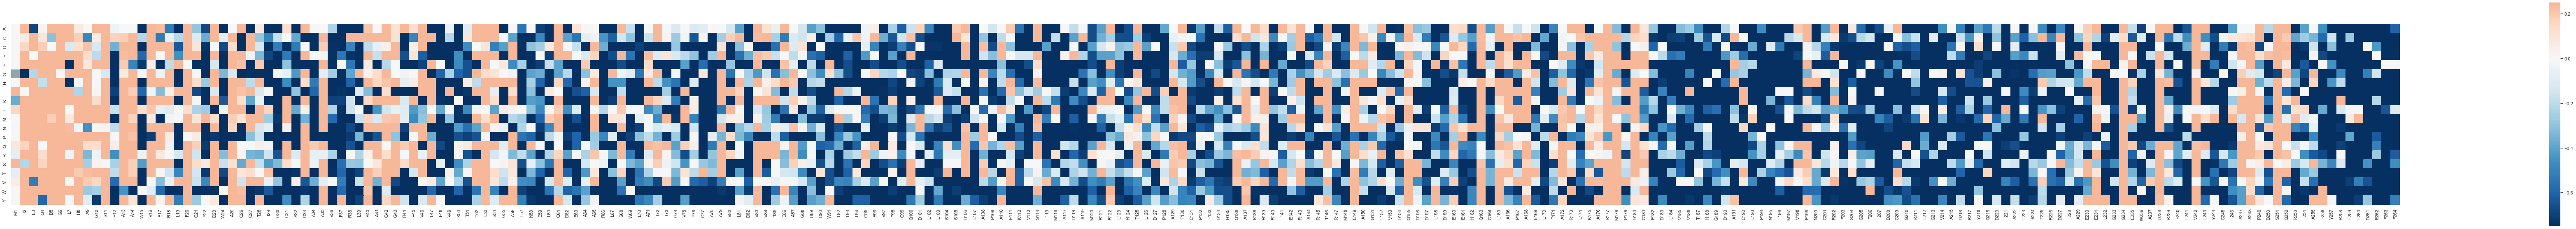

In [26]:
PlotHeatmap(functional_1nd4, vmax=0.25, vmin=-0.75)

## Perturbation Network Data

In [361]:
data_path = os.path.join(protein_path, 'data')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
functional_data = {'1be9':functional_1be9, '1nd4':functional_1nd4, '1d5r':functional_1d5r, '3dqw':functional_3dqw, 
                  '4bz3':functional_4bz3}

First, fix functional DataFrames so they only have positions for which both functional and network data is available.

In [360]:
def CheckData(protein):
    """Returns list of positions (without chain id) in protein for which both DMS and network data is available."""
    functional_columns = set(functional_data[protein].columns)
    # Sample network file
    file = os.path.join(data_path, f'{protein}/{protein}_3.0_weight.csv')
    df = pd.read_csv(file, header=0)
    df_columns = list(df.columns)
    # Since network data has chain id, we need a set of positions without it
    network_columns = set([column[0]+column[2:] for column in df_columns])
    positions = list(network_columns.intersection(functional_columns))
    positions.sort(key = lambda x:int(x[1:]))
    return positions

In [362]:
# Remove columns without both kinds of data
for protein in proteins:
    positions = CheckData(protein)
    df = functional_data[protein]
    df = df[positions]
# Save new data in dictionary again
functional_data = {'1be9':functional_1be9, '1nd4':functional_1nd4, '1d5r':functional_1d5r, '3dqw':functional_3dqw, 
                  '4bz3':functional_4bz3}
# Save with absolute value to focus only on functional change
functional_data_abs = {protein:functional_data[protein].apply(np.abs) for protein in proteins}

In [397]:
def AverageOverChains(protein, threshold, measure):
    """If protein has multiple identical chains, return DataFrame with average values per position. Returns df without
    chain names in columns. """
    file = os.path.join(data_path, f"{protein}/{protein}_{threshold}_{measure}.csv")
    df = pd.read_csv(file, header=0)
    df.index = AA
    # Get how many chains from column names 
    column_names = list(df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction, from modified functional files
    positions = list(functional_data[protein].columns)
    #positions = list(set([c[0]+c[2:] for c in column_names]))
    #positions.sort(key = lambda x:int(x[1:]))
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in df.columns:
                    values.append(df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [370]:
def ReadNetworkCSV(protein, threshold, measure, average=True):
    """Return DataFrame from corresponding CSV. If average, apply AverageOverChains and only show mutations for which 
    both kinds data is available."""
    file = os.path.join(data_path, f"{protein}/{protein}_{threshold}_{measure}.csv")
    # Check that file has same columns as functional
    if average:
        functional = functional_data[protein]
        df = AverageOverChains(protein, threshold, measure)
        positions = list(functional.columns)
        df = df[positions]
    else:
        df = pd.read_csv(file, header=0)
    df.index = AA
    return df

In [373]:
def SampleSpearmanR(protein, average=True, abs=False, thresholds=sample_thresholds):
    """Return DataFrame with Spearman correlation coefficient between functional and network data for mean score 
    over aminoacids."""
    # Check which functional files to use
    if abs: 
        data = functional_data_abs
    else:
        data = functional_data
    functional_df = data[protein]
    functional = list(functional_df.mean())
    spearman = pd.DataFrame(index=thresholds, columns=measures)
    for measure in measures:
        for threshold in thresholds:
            df = ReadNetworkCSV(protein, threshold, measure, average=average)
            compare = list(df.mean())
            spearman.at[threshold, measure] = round(sp.stats.spearmanr(functional, compare)[0], 3)
    spearman.loc['Mean'] = spearman.mean()
    return spearman

In [374]:
def SamplePearsonR(protein, average=True, abs=False, thresholds=sample_thresholds):
    """Return DataFrame with Pearson correlation coefficient between functional and network data for mean score 
    over aminoacids."""
    # Check which functional files to use
    if abs: 
        data = functional_data_abs
    else:
        data = functional_data
    functional_df = data[protein]
    functional = list(functional_df.mean())
    pearson = pd.DataFrame(index=thresholds, columns=measures)
    for measure in measures:
        for threshold in thresholds:
            df = ReadNetworkCSV(protein, threshold, measure, average=average)
            compare = list(df.mean())
            pearson.at[threshold, measure] = round(sp.stats.pearsonr(functional, compare)[0], 3)
    pearson.loc['Mean'] = pearson.mean()
    return pearson

In [253]:
SampleSpearmanR('1be9')

,nodes,edges,weight,distance
3.0,0.215,0.261,0.278,0.197
4.0,0.49,0.53,0.496,0.232
5.0,0.46,0.476,0.454,0.114
6.0,0.5,0.482,0.458,0.024
7.0,0.485,0.478,0.463,0.013
8.0,0.493,0.479,0.458,0.039
9.0,0.478,0.451,0.453,0.118
10.0,0.452,0.452,0.438,0.038
Mean,0.446625,0.451125,0.43725,0.096875


In [248]:
SamplePearsonR('1be9')

,nodes,edges,weight,distance
3.0,0.208,0.254,0.309,0.152
4.0,0.384,0.467,0.446,0.264
5.0,0.359,0.451,0.415,0.197
6.0,0.419,0.461,0.408,0.022
7.0,0.376,0.453,0.401,0.014
8.0,0.384,0.462,0.397,-0.057
9.0,0.364,0.427,0.394,0.015
10.0,0.304,0.423,0.398,-0.071
Mean,0.34975,0.42475,0.396,0.067


In [249]:
SampleSpearmanR('1d5r')

,nodes,edges,weight,distance
3.0,-0.392,-0.397,-0.39,-0.36
4.0,-0.641,-0.643,-0.599,-0.467
5.0,-0.655,-0.636,-0.606,-0.417
6.0,-0.678,-0.645,-0.598,-0.428
7.0,-0.677,-0.644,-0.595,-0.431
8.0,-0.673,-0.648,-0.607,-0.387
9.0,-0.684,-0.655,-0.613,-0.366
10.0,-0.687,-0.657,-0.613,-0.361
Mean,-0.635875,-0.615625,-0.577625,-0.402125


In [250]:
SamplePearsonR('1d5r')

,nodes,edges,weight,distance
3.0,-0.417,-0.423,-0.401,-0.343
4.0,-0.654,-0.659,-0.617,-0.45
5.0,-0.668,-0.652,-0.606,-0.407
6.0,-0.698,-0.67,-0.587,-0.397
7.0,-0.691,-0.666,-0.586,-0.375
8.0,-0.691,-0.663,-0.595,-0.299
9.0,-0.7,-0.666,-0.598,-0.266
10.0,-0.707,-0.67,-0.598,-0.259
Mean,-0.65325,-0.633625,-0.5735,-0.3495


In [257]:
SamplePearsonR('1d5r', abs=True)

,nodes,edges,weight,distance
3.0,0.416,0.423,0.405,0.347
4.0,0.657,0.663,0.624,0.457
5.0,0.669,0.654,0.61,0.416
6.0,0.701,0.675,0.589,0.4
7.0,0.692,0.67,0.586,0.369
8.0,0.691,0.666,0.593,0.29
9.0,0.7,0.668,0.595,0.26
10.0,0.707,0.673,0.594,0.252
Mean,0.654125,0.6365,0.5745,0.348875


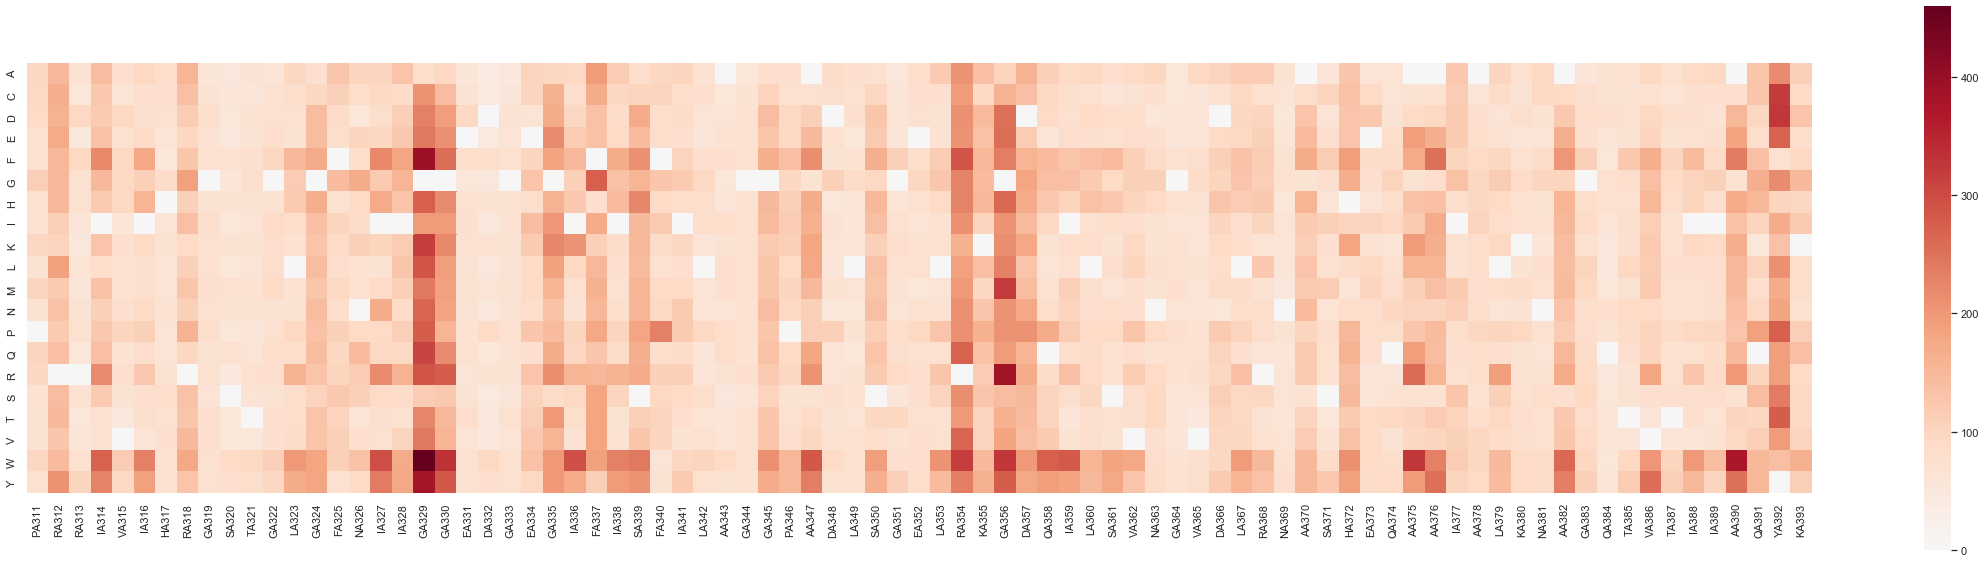

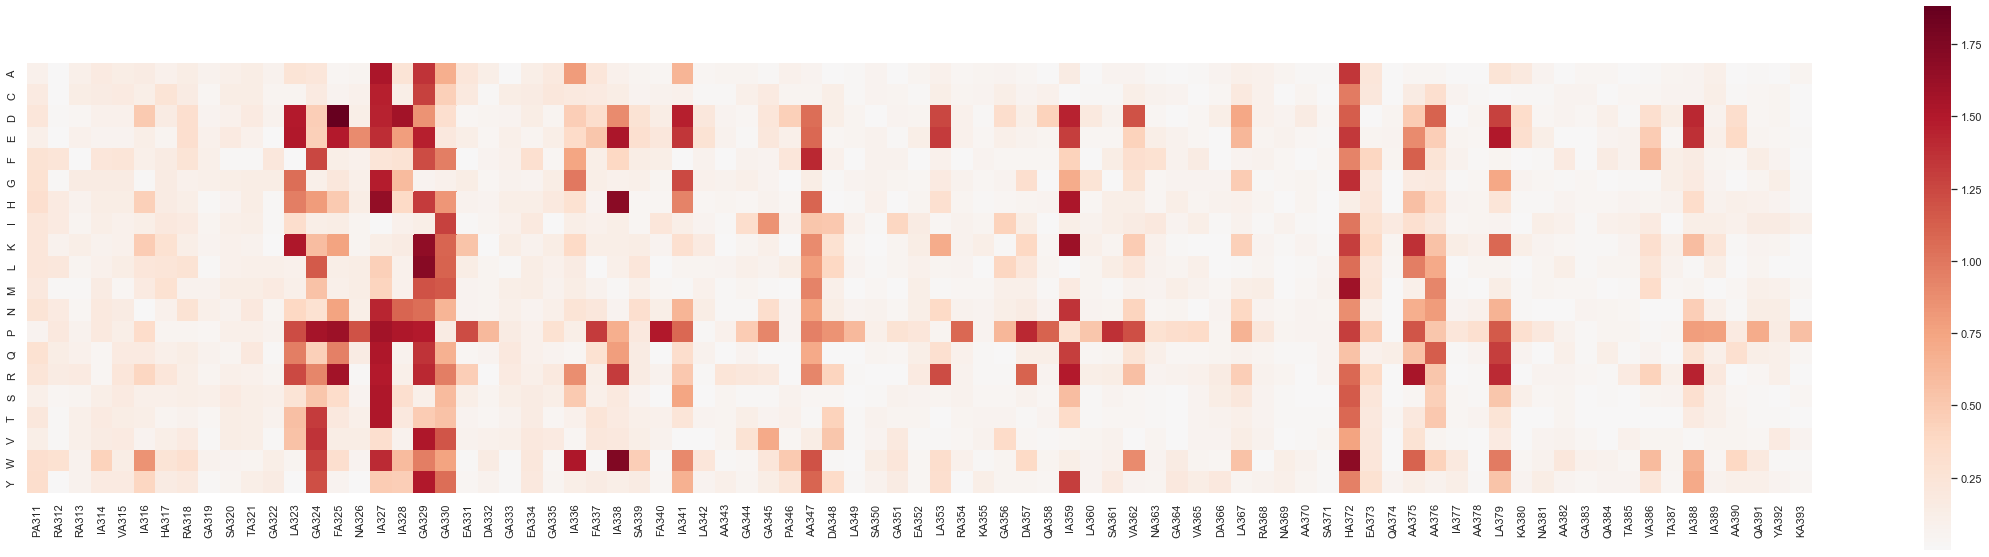

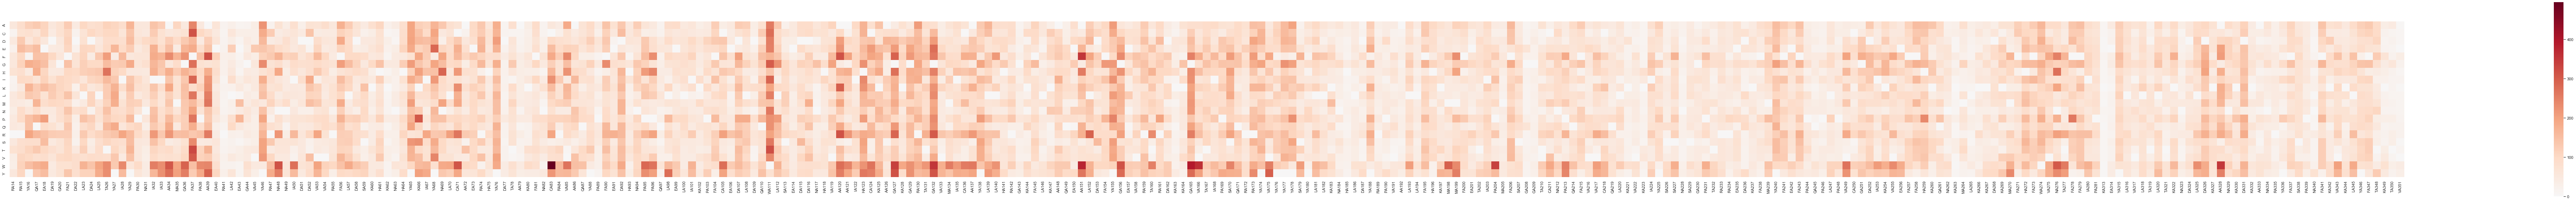

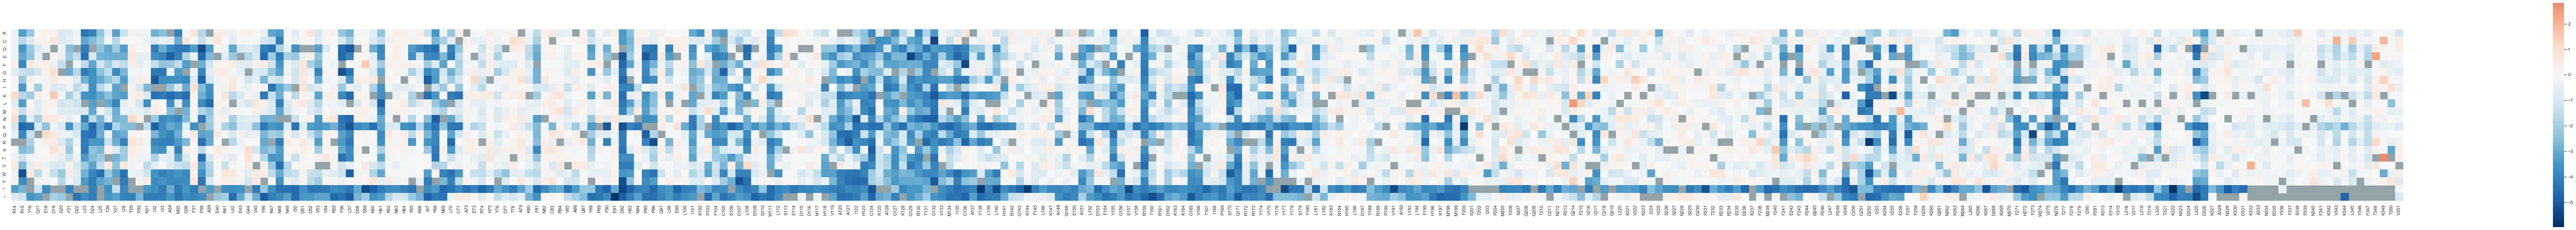

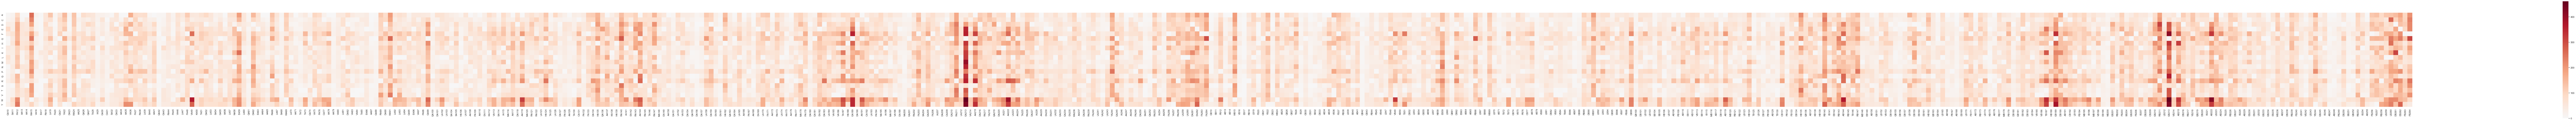

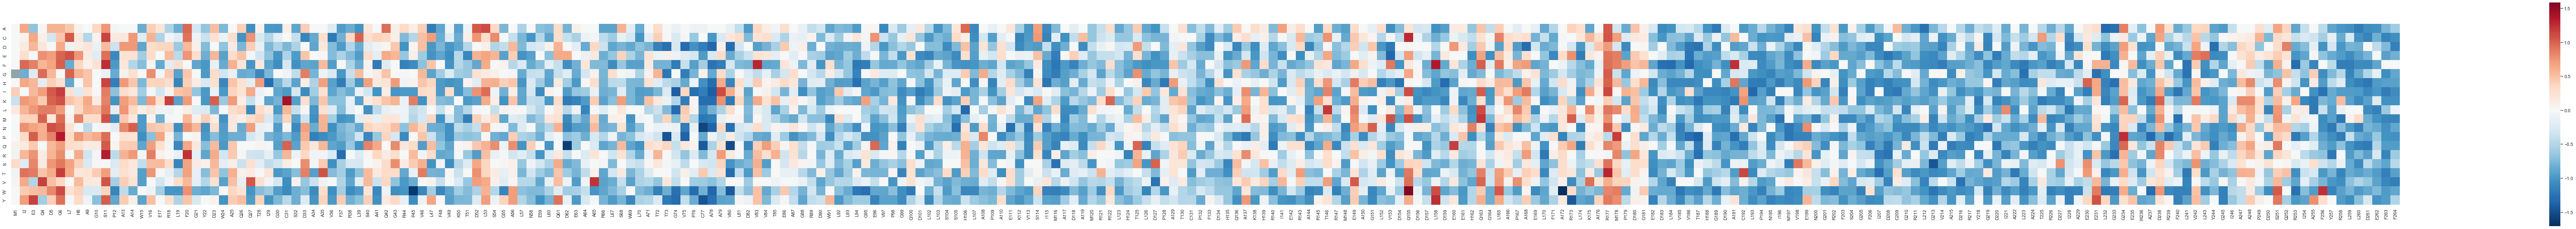

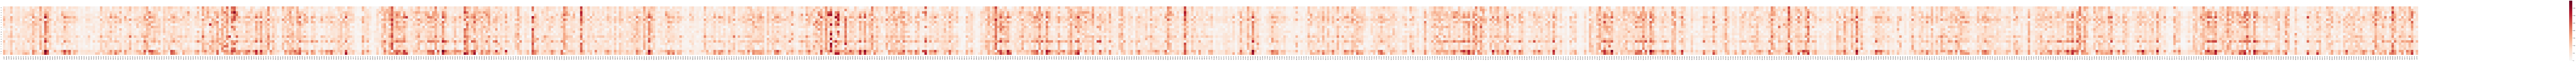

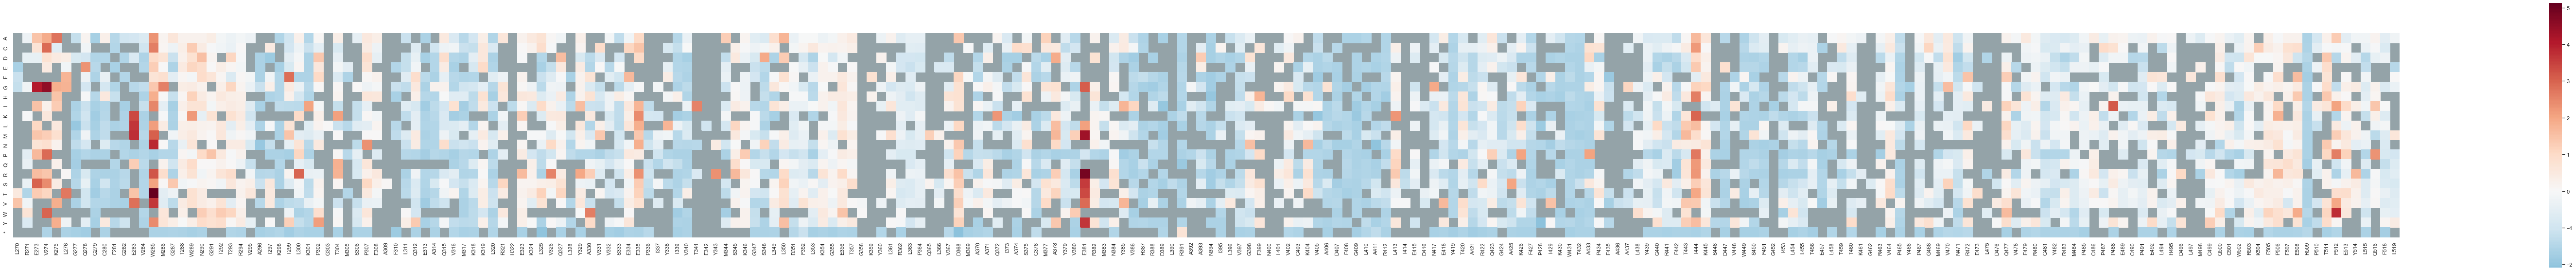

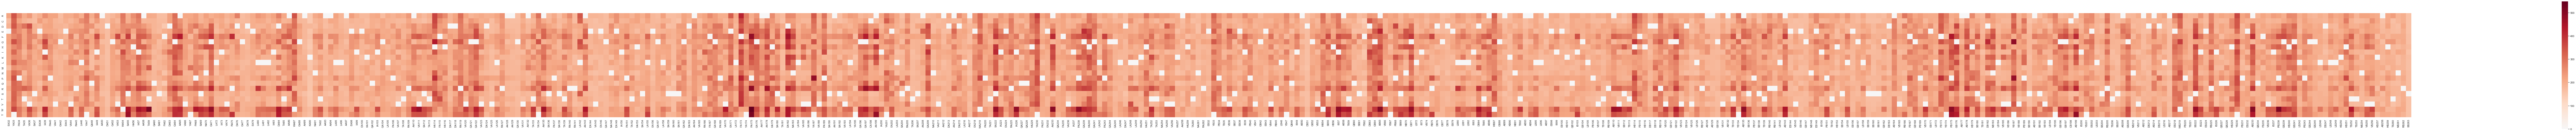

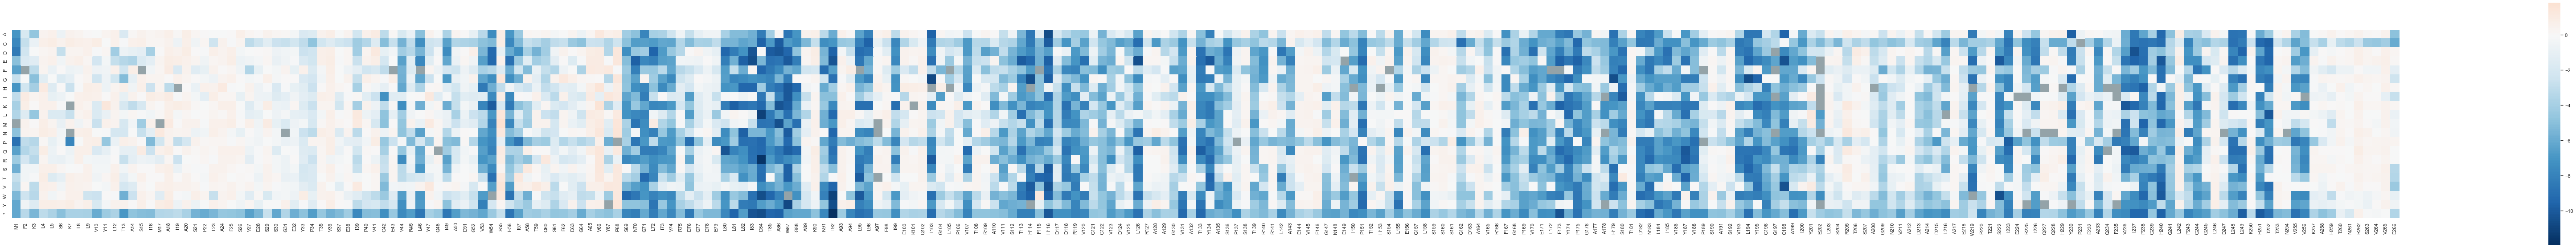

In [285]:
threshold = '5.0'
measure = 'weight'
for protein in proteins:
    df = ReadNetworkCSV(protein, threshold, measure)
    functional = functional_data[protein]
    PlotHeatmap(df)
    PlotHeatmap(functional)

Ideas: 
   - Comparar promedios por posición para ver si las posiciones más sensibles se distinguen
   - Ver si un threshold es más ilustrativo que otros
       - Parece que 3 es malo, los demás son parecidos
   - Ver si una característica es más ilustrativa que otra
       - Parece que distance no es tan bueno como los otros
   

Checar:
   - Parece que 3dqw functional y el pdb no tienen exactamente la misma secuencia...